In [1]:
# Kütüphaneleri Yükleyelim

import os
import keras
import tensorflow as tf
#from keras.applications import DenseNet201
from keras.applications.densenet import DenseNet201
from keras.applications.xception import Xception
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import NASNetLarge

from keras import layers
from keras import models
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam, RMSprop
#from keras.optimizers import Adam, RMSprop

from datetime import datetime
import time

In [2]:
!pip install split-folders

In [ ]:
!unzip earthquake.zip

In [ ]:
import splitfolders
Data="data"
splitfolders.ratio(Data, output="earthquake", seed=1337, ratio=(.8,.2))

Copying files: 2735 files [00:00, 9136.31 files/s]


In [4]:
base_dir = '/content/earthquake'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [5]:
InceptionResNetV2
conv_base = InceptionResNetV2(weights='imagenet',
                            include_top = False,
                            input_shape = (224,224,3))

219055592/219055592 [==============================] - 1s 0us/step


In [6]:
#ResNet152V2
conv_base = ResNet152V2(weights='imagenet',
                        include_top = False,
                        input_shape = (224,224,3))

234545216/234545216 [==============================] - 1s 0us/step


In [7]:
#Xception
conv_base = Xception(weights='imagenet',
                    include_top = False,
                    input_shape = (224,224,3))

83683744/83683744 [==============================] - 0s 0us/step


In [8]:
#DenseNet201
conv_base = DenseNet201(weights='imagenet',
                        include_top = False,
                        input_shape = (224,224,3))

74836368/74836368 [==============================] - 0s 0us/step


In [15]:
# katmanları ekle

x = conv_base.output

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

x_output = layers.Dense(1, activation='sigmoid')(x)
model=Model(inputs=conv_base.input,outputs=x_output)

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_4[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size = 16,  # 2^ sayılardan olmalı. 16/32/64 gibi. veri setine uydurmak gerek
    #veriyi 8 li gruplar halinde geçiriyor. önceki çalışmalarımda 16 kullandım.
    class_mode = "binary")   #çoklu sınıflandırmada "categorical"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (250,250),
    batch_size = 16,   # 2^ sayılardan olmalı. 16/32/64 gibi. veri setine uydurmak gerek
    #veriyi 8 li gruplar halinde geçiriyor. önceki çalışmalarımda 16 kullandım.
    class_mode = "binary",  #çoklu sınıflandırmada "categorical"
    shuffle = False)  #veri setini sırasıyla kontrol ediyor. True olursa karışık.

Found 1913 images belonging to 2 classes.
Found 272 images belonging to 2 classes.


In [18]:
# modeli derle
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(2e-5),
              metrics = ['accuracy'])

In [19]:
#Model eğitilirken %98 doğruluğa ulaştığında eğitimi durdur.
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.98*100))
            self.model.stop_training = True
callback= myCallback()

In [20]:
# model eğit

baslangic=time.time()
history = model.fit_generator(
    train_generator,
    epochs = 1000,
    validation_data = validation_generator,
    callbacks=[callback])

Epoch 1/1000


<ipython-input-20-ce8f605f713a>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


120/120 [==============================] - 137s 348ms/step - loss: 0.0624 - accuracy: 0.9786 - val_loss: 0.1467 - val_accuracy: 0.9449
Epoch 2/1000
120/120 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9937
Reached 98.00% accuracy, so stopping training!!
120/120 [==============================] - 38s 315ms/step - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.0591 - val_accuracy: 0.9706


In [21]:
# Model Kaydet

model.save('earthquake.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


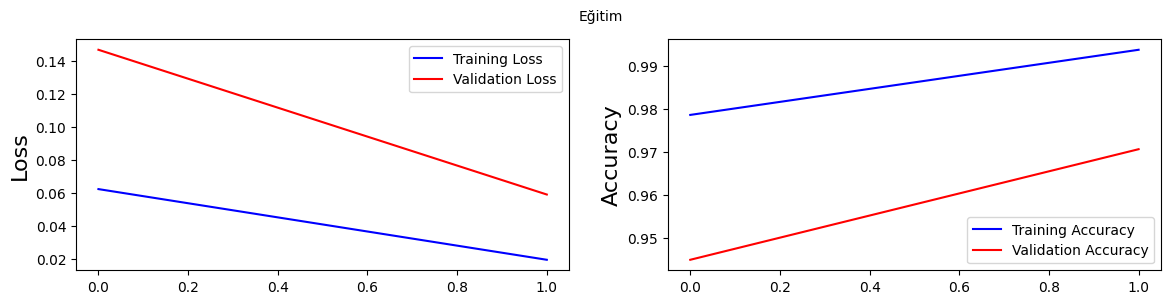

In [23]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)

plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.savefig('plt.png', dpi = 600, transparent = True)

plt.subplot(1, 2, 2)

plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')

plt.legend(loc='lower right')

plt.savefig('plt2.png', dpi = 600, transparent = True)

plt.show()

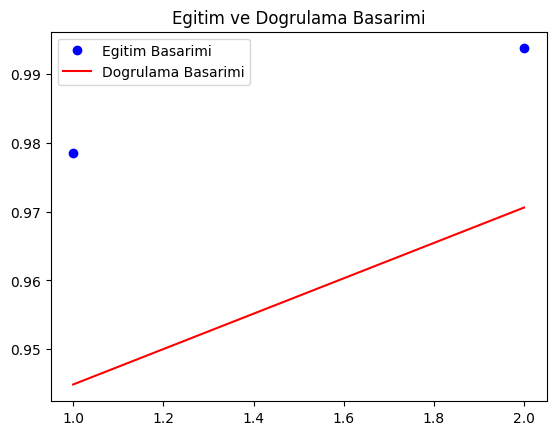

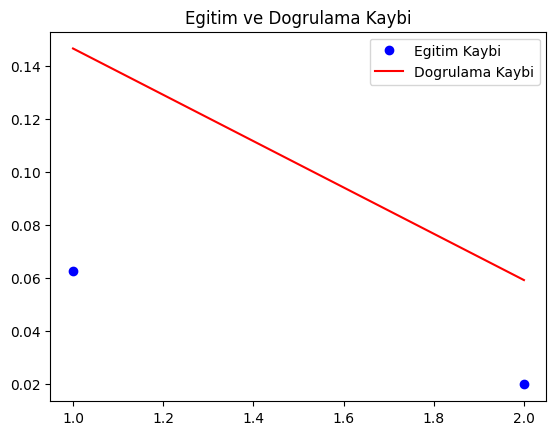

In [24]:
# Sonuçları çizdirme
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.figure()
plt.plot(epochs,acc,'bo',label=u'Egitim Basarimi')
plt.plot(epochs,val_acc,'r',label=u'Dogrulama Basarimi')
plt.title(u'Egitim ve Dogrulama Basarimi')
plt.legend()
plt.savefig('plt3.png', dpi = 600, transparent = True)

plt.figure()
plt.plot(epochs,loss,'bo',label=u'Egitim Kaybi')
plt.plot(epochs,val_loss,'r',label=u'Dogrulama Kaybi')
plt.title(u'Egitim ve Dogrulama Kaybi')
plt.legend()
plt.savefig('plt4.png', dpi = 600, transparent = True)

plt.show()